# 0. Imports

In [62]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
from tqdm import tqdm

In [32]:
# Configure tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
else:
  print("No GPU was detected. TensorFlow will not use the GPU.")

No GPU was detected. TensorFlow will not use the GPU.


# 1. Load data

In [33]:
df = pd.read_csv("./data/star_classification.csv")
df.shape

(100000, 18)

# 2. EDA on the data

## 2.1 Dropping all columns ending with _ID

In [34]:
df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [35]:
df.drop(df.columns[df.columns.str.endswith('_ID')], axis=1, inplace=True)
df.head()

,alpha,delta,u,g,r,i,z,cam_col,class,redshift,plate,MJD
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,2,GALAXY,0.634794,5812,56354
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,5,GALAXY,0.779136,10445,58158
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,2,GALAXY,0.644195,4576,55592
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,3,GALAXY,0.932346,9149,58039
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,3,GALAXY,0.116123,6121,56187


## 2.2 Describing the various `categories` in class

In [36]:
def cls_to_label(x):
    if x == "GALAXY":
        return 0
    elif x == "QSO":
        return 1
    else:
        return 2

def cls_to_str(x):
    if x == 0:
        return "GALAXY"
    elif x == 1:
        return "QSO"
    else:
        return "STAR"

df["class"] = df["class"].apply(cls_to_label)
df.head()

,alpha,delta,u,g,r,i,z,cam_col,class,redshift,plate,MJD
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,2,0,0.634794,5812,56354
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,5,0,0.779136,10445,58158
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,2,0,0.644195,4576,55592
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,3,0,0.932346,9149,58039
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,3,0,0.116123,6121,56187


## 2.2 Applying Kendall's correlation for feature selection and not assume linearity

<Axes: >

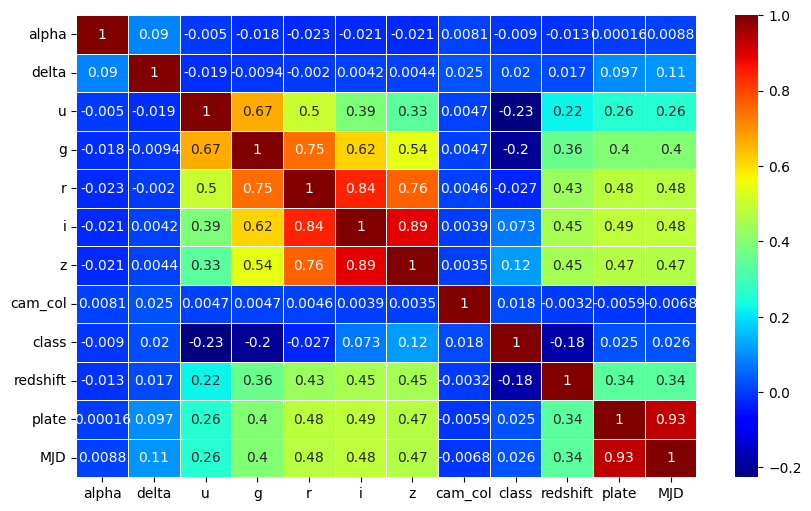

In [37]:
f, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(df.corr(method="kendall"), annot=True, linewidths=.5, ax=ax, cmap="jet")

## 2.3 Droping outliers

In [38]:
df["u"] = df["u"].apply(lambda x: x if x > -1 else None)
df["g"] = df["g"].apply(lambda x: x if x > -1 else None)
df["z"] = df["z"].apply(lambda x: x if x > -1 else None)

In [39]:
df.dropna(inplace=True)

## 2.4 Keep only varible `u`, `g`, `z`& `redshift` as they are most significant

In [40]:
df_pruned = df[["u", "g", "z", "redshift", "class"]]

## 2.5 Validating distribution of predicting variables

### 2.5.1 Validating attribute `U`

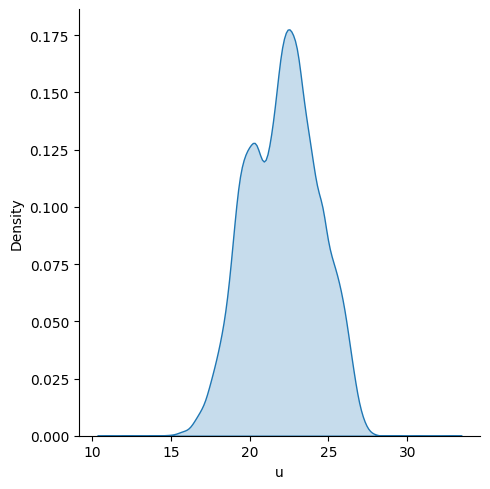

In [41]:
sns.displot(df_pruned, x="u", kind="kde", fill=True)

### 2.5.2 Validating the attribute `G`

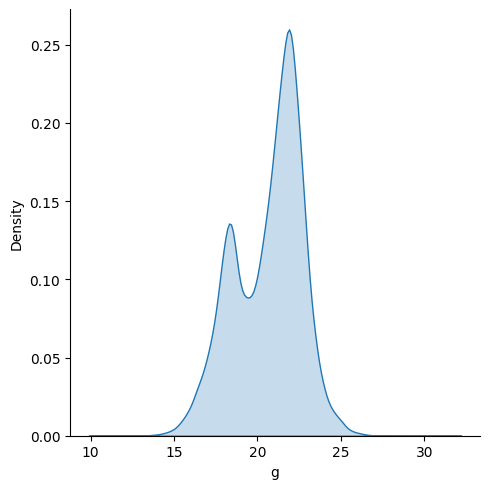

In [42]:
sns.displot(df_pruned, x="g", kind="kde", fill=True)

### 2.5.3 Validating the attribute `Z`

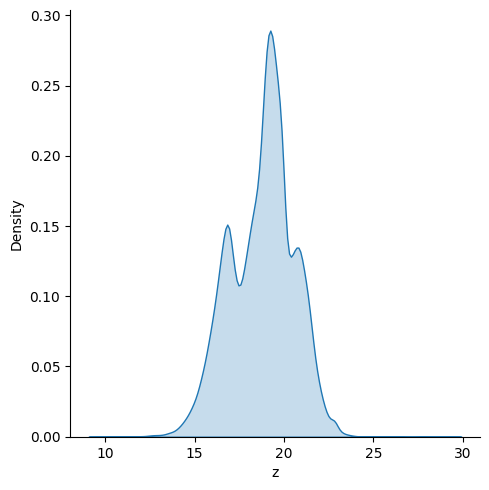

In [43]:
sns.displot(df_pruned, x="z", kind="kde", fill=True)

### 2.5.4 Validating the attribute `red-shift`

#### 2.5.4.1 Checking distribution

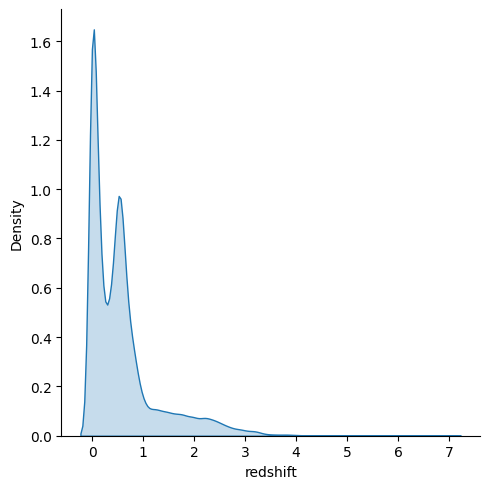

In [44]:
sns.displot(df_pruned, x="redshift", kind="kde", fill=True)

In [45]:
df_pruned["redshift"].skew()

2.5235985229261972

#### 2.5.4.2 Log Normalizing to reduce skew

In [46]:
df_pruned["redshift_sqrt"] = np.sqrt(df_pruned["redshift"])

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-46-ef9acfb272f2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pruned["redshift_sqrt"] = np.sqrt(df_pruned["redshift"])


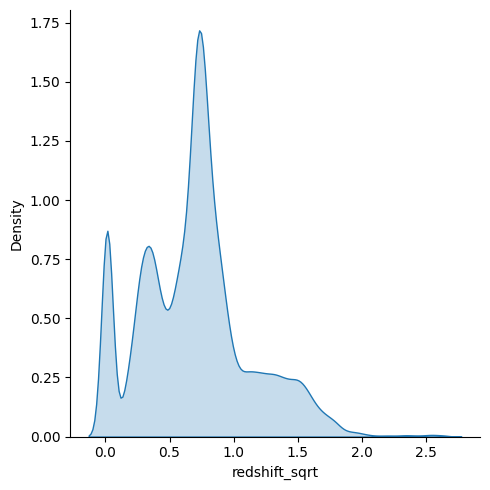

In [47]:
sns.displot(df_pruned, x="redshift_sqrt", kind="kde", fill=True)

In [48]:
df_pruned["redshift_sqrt"].skew()

0.5611486871685141

## 2.6 Describing the final df

In [49]:
df_pruned.dropna(inplace=True)
df_pruned.describe()

<ipython-input-49-1d79a0fe547b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pruned.dropna(inplace=True)


,u,g,z,redshift,class,redshift_sqrt
count,86275.000000,86275.000000,86275.000000,86275.000000,86275.000000,86275.000000
mean,22.240384,20.801111,18.834112,0.668451,0.403164,0.698134
std,2.192517,1.972774,1.744112,0.746650,0.651167,0.425514
min,10.996230,10.498200,9.612333,0.000000,0.000000,0.000000
25%,20.569335,19.313910,17.605945,0.147191,0.000000,0.383655
50%,22.330310,21.277860,19.065370,0.500827,0.000000,0.707691
75%,23.784980,22.212820,19.939560,0.782358,1.000000,0.884510
max,32.781390,31.602240,29.383740,7.011245,2.000000,2.647876


## 2.7 Converting the Y to a onehot encoded form

In [50]:
Y_df = df_pruned["class"]
del df

In [51]:
Y_onehot_df = pd.get_dummies(Y_df, dtype=float)

## 2.8 Convert X & Y to a tf Tensor

In [52]:
X = tf.constant(df_pruned)
Y = tf.constant(Y_onehot_df)

## 2.9 Convert train test split

In [53]:
tt_boundary = int(0.8 * len(X))
X_train = X[:tt_boundary]
Y_train = Y[:tt_boundary]
X_test = X[tt_boundary:]
Y_test = Y[tt_boundary:]

# 3. Modelling

## 3.1 Model Definition

In [83]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(X_train.shape[-1]),
    tf.keras.layers.Dense(3, activation="softmax")
], name="Stellar_Model")

## 3.2 Model compilation

In [84]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy]
)

## 3.3 Model training

In [85]:
history = model.fit(
    X_train,
    Y_train,
    epochs=10,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
1726/1726 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - categorical_accuracy: 0.8469 - loss: 0.5424 - val_categorical_accuracy: 0.9788 - val_loss: 0.1056
Epoch 2/10
1726/1726 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - categorical_accuracy: 0.9866 - loss: 0.0768 - val_categorical_accuracy: 0.9921 - val_loss: 0.0304
Epoch 3/10
1726/1726 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - categorical_accuracy: 0.9947 - loss: 0.0259 - val_categorical_accuracy: 0.9988 - val_loss: 0.0109
Epoch 4/10
1726/1726 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - categorical_accuracy: 0.9983 - loss: 0.0094 - val_categorical_accuracy: 0.9999 - val_loss: 0.0042
Epoch 5/10
1726/1726 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - categorical_accuracy: 0.9994 - loss: 0.0041 - val_categorical_accuracy: 0.9999 - val_loss: 0.0016
Epoch 6/10
1726/1726 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - categorical_accuracy: 0.9999 - loss: 0.0020 - val_categorical_accuracy: 1.0000 - val_loss: 7.7694e-04
Epoch 7/10
1726/1726 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - categorical_accu

## 3.4 Plot training curves

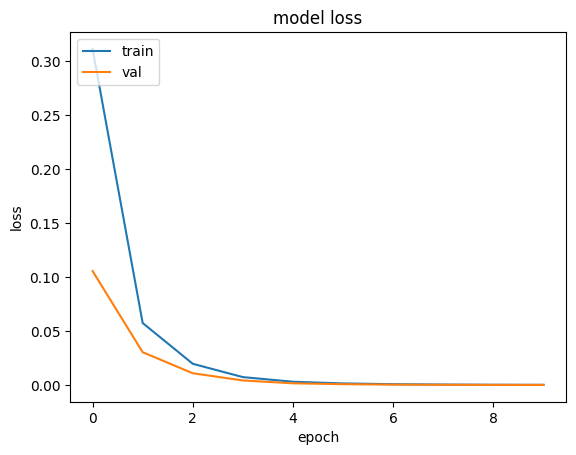

In [86]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

## 3.5 Retrieve Model Accuracy for test set

In [87]:
Y_pred = []
for x in tqdm(X_test):
    Y_pred.append(model.predict(tf.reshape(x, (1,X_train.shape[-1])), verbose=0))

100%|██████████| 17255/17255 [24:50<00:00, 11.58it/s]


In [88]:
score = []
for prediction, observed in zip(Y_pred, Y_test):
    if np.argmax(tf.squeeze(prediction)) == np.argmax(tf.squeeze(observed)):
        score.append(1)
    else:
        score.append(0)
        print("FALSE")

In [90]:
print(f"Accuracy is: {sum(score)/len(score)}")

Accuracy is: 0.9289
